# Modeling Oscillations with an Auto Catalysis Mechanism


This code models the progress of an autocatalysis mechanism in a CSTR exhibiting nonlinear oscillatory behavoir 



## Reference 

[1] Vlachos, D. "CHEG841 Class Notes" Department of Chemical Engineering, University of Delaware 



Date: 07-19-2019


# Table of contents


- [1. Introduction](#introduction)

    
- [2. General approaches](#generalapproaches)
    
    
- [3. Case Study (a Gene Expression mechanism)](#case)

    - [3.1. Tau-leaping](#tauleaping)

    - [3.2. Mean-Field ODEs](#ode)
    
    
- [4. Discussion](#discussion)


# 1. Introduction<a name="introduction"></a>

Goal: to track the number of molecules of each type as a function of reaction time

Assumption: a well-mixed system, where moleculses of each type are spread uniformaly throughout the spatial domain
    
# 2. General approaches<a name="generalapproaches"></a>   

- __Kinetic Monte Carlo (kMC)__ , solving chemical matser equations through 
    - Tau-leaping methods
- Reaction Rate equations through the __mean-field ODEs__

Note: the gillespie's algorithm was too slow and was not adapted.

# 3. Case Study (an Auto-Catalysis mechanism)<a name="case"></a>   

The system involves 2 species:
- a substrate, $A$
- an autocatalyst, $B$
- a product, $C$

The reaction take place in a CSTR with a residence time $\tau_{R}$ and a volume $vol$

Two reactions can be written as

1. $A + 2B \xrightarrow{\text{k1}} 3B$
2. $B \xrightarrow{\text{k2}} C$  (decomposition of B)

Where c0 and c1 are rate constants.

The deterministic transient material balance in a constant volume CSTR:

$\frac{dC_{A}}{dt} = \frac{C_{A,in} - C_{A}}{\tau_{R}} - k_{1}C_{A}C_{B}^2$

$\frac{dC_{B}}{dt} = \frac{C_{B,in} - C_{B}}{\tau_{R}} + k_{1}C_{A}C_{B}^2 - k_{2}C_{B} $



The following mappings between continuum and microscopic variables are used:

- From concentration to species population: $x_{j, in} = C_{j, in} vol N_{av}$


- For rate constants: $c = k/(vol N_{av})^{n-1}$

Where $N_{av}$ is avogadro's number

In [23]:
# Imports Necessary Libraries
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.integrate import odeint, ode

## 3.1 Tau-leaping<a name="tauleaping"></a>   

### Scenario 1 (including decomposition of B)

- Inlet concentrations

    - $C_{A,in} = 1 mol/L $
    
    - $C_{B,in} = 1/15 mol/L $


- The parameters are:

    - $k_{1} = 1 (L/mol)^{2} min $

    - $k_{2} = 1/15 min^{-1}$

    - $\tau = 250 min $
   
    - $ vol = TBD $

In [24]:
def tau_leap(pop, xAin, xBin, c, tauR, tfinal, tau):
    data = np.array([(0, pop[0], pop[1])]) #Store time, XA, XB
    
    V = np.array([(1, -1, 0, 0, -1, 0), (0, 0, 1, -1, 1, -1)]) # Matrix of reaction vectors
    
    # Updates concentrations over timeframes until tfinal is reached
    for k in range(round(tfinal/tau)):
        a=np.zeros((6,1)) # Probabilities of reactions
        a[0] = xAin/tauR;
        a[1] = pop[0]/tauR;
        a[2] = xBin/tauR;
        a[3] = pop[1]/tauR;
        a[4] = c[0]*pop[0]*pop[1]*(pop[1]-1);
        a[5] = c[1]*pop[1];

        # Uses normally distributed random numbers to determine extents if reaction
        d=np.zeros((6,1))
        d[0] = tau*a[0] + np.sqrt(abs(tau*a[0]))*np.random.randn()
        d[1] = tau*a[1] + np.sqrt(abs(tau*a[1]))*np.random.randn()
        d[2] = tau*a[2] + np.sqrt(abs(tau*a[2]))*np.random.randn()
        d[3] = tau*a[3] + np.sqrt(abs(tau*a[3]))*np.random.randn()
        d[4] = tau*a[4] + np.sqrt(abs(tau*a[4]))*np.random.randn()
        d[5] = tau*a[5] + np.sqrt(abs(tau*a[5]))*np.random.randn()

        # Updates concentrations
        pop = pop + d[0]*V[:,0] + d[1]*V[:,1] + d[2]*V[:,2] + d[3]*V[:,3] \
                + d[4]*V[:,4] + d[5]*V[:,5]
        data = np.append(data, [(k*tau, pop[0], pop[1])], axis = 0)
 
    return data

### If we use a bigger simlutaion volume

$ vol = 10^5 nm^{3} = 10^{-19} L$

In [25]:
# define the parameters
np.random.seed(4)

V = np.array([(1, -1, 0, 0, -1, 0), (0, 0, 1, -1, 1, -1)]) # Matrix of reaction vectors

nA = 6.023e23; #Avogadro's Number
vol = 1e-19; #Volume
cAin = 1; #Input concentrations, M/min
cBin = 1/15;
xAin = cAin*nA*vol #Input populations, molecules/minute
xBin = cBin*nA*vol
Y = np.zeros(2) #Populations of molecules
Y[0] = round(xAin)
Y[1] = round(xBin)
c=np.zeros(2) #Reaction rate constants
k1 = 1
k2 = 1/40
c[0] = k1/(vol*nA)**2;
c[1] = k2;  

tfinal = 3000 #time related variables
tau = .1
tauR = 250

start = time.time()
print('Starting kMC simulations...')

# Run the simulation
val_ts1 = tau_leap(Y, xAin, xBin, c, tauR, tfinal, tau)

end = time.time()
print('The simulation takes {0:.4f} s'.format(end-start))

Starting kMC simulations...
The simulation takes 7.8921 s


Text(0, 0.5, '[B]')

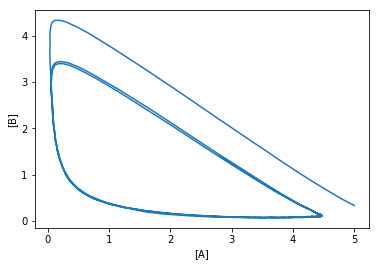

In [50]:
#Plots concentrations against each other
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(val_ts1[:,1]/nA/vol,val_ts1[:,2]/nA/vol)
ax.set_xlabel('[A]')
ax.set_ylabel('[B]')

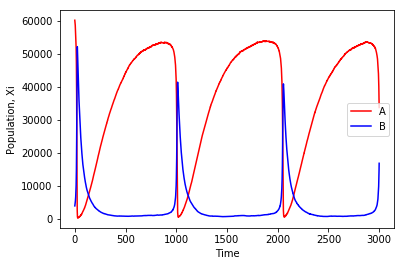

In [27]:
# Plot species population against time
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(val_ts1[:,0],val_ts1[:,1], 'r');
ax.plot(val_ts1[:,0],val_ts1[:,2], 'b');
ax.set_xlabel('Time')
ax.set_ylabel('Population, Xi');
plt.legend(['A', 'B']);

### If we use a smaller simlutaion volume, the curve becomes more erratic.

$ vol = 10^3 nm^{3} = 10^{-21} L$

In [28]:
# If we decrease the volume, 
22
vol = 1e-21
xAin = cAin*nA*vol
xBin = cBin*nA*vol
Y = np.zeros(2)
Y[0] = round(xAin)
Y[1] = round(xBin)
c=np.zeros(2)
c[0] = 1/(vol*nA)**2;
c[1] = 1/40;

start = time.time()
print('Starting kMC simulations...')

# Run the simulation
val_ts2 = tau_leap(Y, xAin, xBin, c, tauR, tfinal, tau)

end = time.time()
print('The simulation takes {0:.4f} s'.format(end-start))

Starting kMC simulations...
The simulation takes 8.1661 s


Text(0, 0.5, '[B]')

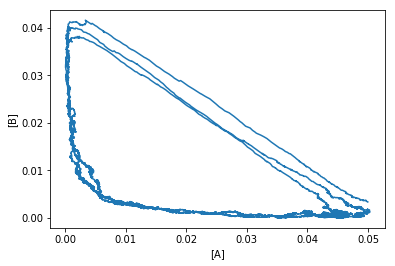

In [48]:
#Plots concentrations against each other
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(val_ts2[:,1]/nA/vol,val_ts2[:,2]/nA/vol)
ax.set_xlabel('[A]')
ax.set_ylabel('[B]')

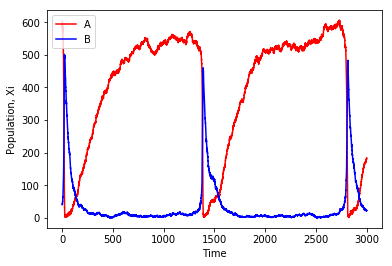

In [30]:
# Plot sepcies population against time
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(val_ts2[:,0],val_ts2[:,1], 'r');
ax.plot(val_ts2[:,0],val_ts2[:,2], 'b');
ax.set_xlabel('Time')
ax.set_ylabel('Population, Xi');
plt.legend(['A', 'B']);

### Scenario 2 (no decomposition of B)

- Inlet populations

    - $X_{A,in} = 12000 $
    
    - $X_{B,in} = 500 $


- The parameters are:

    - $k_{1} = 6.2 (L/mol)^{2} min $

    - $k_{2} = 0 min^{-1}$

    - $\tau = 1 min $
    
    - $ vol = 2*10^4 nm^{3} = 2*10^{-20} L$

In [31]:
# Here we transition to simulating the system without decomposition of the 
# catalyst, meaning c1 is 0

vol = 2e-20
xAin = 12000
xBin = 500
Y = np.zeros(2)
Y[0] = round(xAin)
Y[1] = round(xBin)
c=np.zeros(2)
k1 = 6.2
k2 = 0
c[0] = k1/(vol*nA)**2;
c[1] = k2; 

tfinal = 700
tau = .1
tauR = 1

start = time.time()
print('Starting kMC simulations...')

# Run the simulations
val_ts3 = tau_leap(Y, xAin, xBin, c, tauR, tfinal, tau)

end = time.time()
print('The simulation takes {0:.4f} s'.format(end-start))

Starting kMC simulations...
The simulation takes 0.8762 s


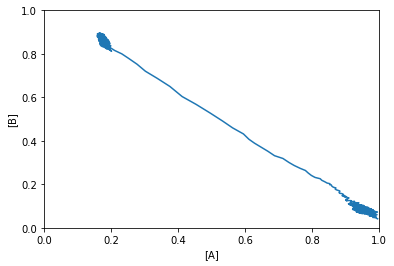

In [46]:
#Plots concentrations against each other
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(val_ts3[:,1]/nA/vol,val_ts3[:,2]/nA/vol)
ax.set_xlabel('[A]')
ax.set_ylabel('[B]')
ax.set_xlim([0,1]);
ax.set_ylim([0,1]);

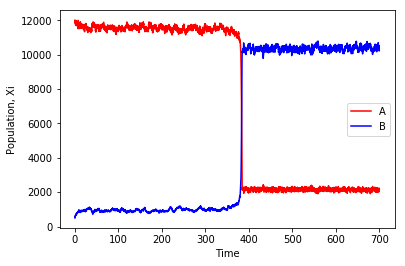

In [33]:
# Plot molecules against time
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(val_ts3[:,0],val_ts3[:,1], 'r');
ax.plot(val_ts3[:,0],val_ts3[:,2], 'b');
ax.set_xlabel('Time')
ax.set_ylabel('Population, Xi');
plt.legend(['A', 'B']);

## 3.2 Mean-Field ODEs <a name="ode"></a>   

In [34]:
def kin(t,y): # kinetics of the reaction for each molecule
    yprime = np.zeros(2);
    yprime[0] = cAin/tauR - y[0]/tauR - k1*y[0]*y[1]**2
    yprime[1] = cBin/tauR - y[1]/tauR + k1*y[0]*y[1]**2- k2*y[1];
    return yprime

### Scenario 1 (including decomposition of B)

- Inlet concentrations

    - $C_{A,in} = 1 mol/L $
    
    - $C_{B,in} = 1/15 mol/L $


- The parameters are:

    - $k_{1} = 1 (L/mol)^{2} min $

    - $k_{2} = 1/15 min^{-1}$

    - $\tau = 250 min $
    
    - $ vol = NaN $ ($vol$ not used in mean-field)

In [35]:
tspan = np.array([0,16000])

nA = 6.023e23
vol = 1e-19 # in L, 1e5 nm3
cAin = 1 ##Input concentrations, M/min
cBin = 1/15

y0 = np.zeros(2) #Initial concentrations
y0[0] = cAin
y0[1] = cBin

k1 = 1 #(L/mol)^2 min
k2 = 1/40 #min-1

tauR = 250 #min

In [36]:
solver1=ode(kin).set_integrator('vode',rtol=1e-5,method='bdf') # Feeds information to vode, an ode15s equivalent
solver1.set_initial_value(y0,tspan[0])
t, yout= [tspan[0]],[y0]

# the time step to output the results 
dt = 0.01 

start = time.time()

while solver1.successful() and solver1.t < tspan[1]:
    solver1.integrate(solver1.t+dt, step=True)
    t.append(solver1.t)
    yout.append(solver1.y)
    
end = time.time()
print('Solving odes takes {0:.4f} s'.format(end-start))

t_o1 = np.array(t)
yout_o1 = np.array(yout)

Solving odes takes 0.1170 s


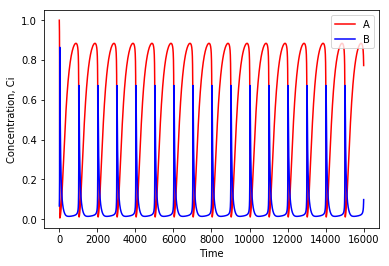

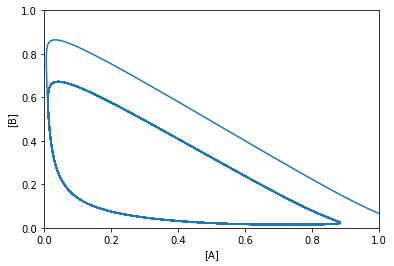

In [51]:
CA_o1 = yout_o1[:,0] 
CB_o1 = yout_o1[:,1]

fig = plt.figure() # Produces plots of the data
ax = fig.add_subplot(111)
ax.set_xlabel('Time')
ax.plot(t_o1,CA_o1,'r')
ax.plot(t_o1,CB_o1, 'b')
ax.set_ylabel('Concentration, Ci');
plt.legend(['A', 'B']);


fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('[A]')
ax.set_ylabel('[B]');
ax.set_xlim([0,1]);
ax.set_ylim([0,1]);
ax.plot(CA_o1,CB_o1);


### Scenario 2 (no decomposition of B)

- Inlet populations

    - $X_{A,in} = 12000 $
    
    - $X_{B,in} = 500 $


- The parameters are:

    - $k_{1} = 6.2 (L/mol)^{2} min $

    - $k_{2} = 0 min^{-1}$

    - $\tau = 1 min $
    
    - $ vol = 2*10^4 nm^{3} = 2*10^{-20} L$

In [41]:
# Here we transition to simulation the system without decomposition of the 
# catalyst, meaning c1 is 0

tspan = np.array([0,700])
vol = 2e-20
xAin = 12000
xBin = 500
cAin = xAin/nA/vol
cBin = xBin/nA/vol

y0 = np.zeros(2)
y0[0] = cAin
y0[1] = cBin

k1 = 6.2
k2 = 0

tauR = 1

In [42]:
# update the ode solver
def kin(t,y): # kinetics of the reaction for each molecule
    yprime = np.zeros(2);
    yprime[0] = cAin/tauR - y[0]/tauR - k1*y[0]*y[1]**2
    yprime[1] = cBin/tauR - y[1]/tauR + k1*y[0]*y[1]**2- k2*y[1];
    return yprime

In [43]:
solver2=ode(kin).set_integrator('vode',rtol=1e-5,method='bdf') # Feeds information to vode, an ode15s equivalent
solver2.set_initial_value(y0,tspan[0])
t, yout= [tspan[0]],[y0]

# the time step to output the results 
dt = 0.01 
start = time.time()

while solver2.successful() and solver2.t < tspan[1]:
    solver2.integrate(solver2.t+dt, step=True)
    t.append(solver2.t)
    yout.append(solver2.y)
    
end = time.time()
print('Solving odes takes {0:.4f} s'.format(end-start))

t_o2 = np.array(t)
yout_o2 = np.array(yout)

Solving odes takes 0.0350 s


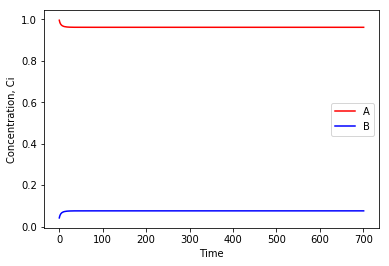

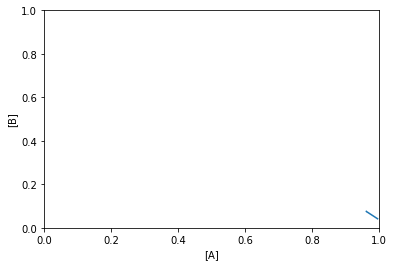

In [53]:
CA_o2 = yout_o2[:,0] 
CB_o2 = yout_o2[:,1]

fig = plt.figure() # Produces plots of the data
ax = fig.add_subplot(111)
ax.set_xlabel('Time')
ax.plot(t_o2,CA_o2,'r')
ax.plot(t_o2,CB_o2, 'b')
ax.set_ylabel('Concentration, Ci');
plt.legend(['A', 'B']);


fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('[A]')
ax.set_ylabel('[B]');
ax.set_xlim([0,1]);
ax.set_ylim([0,1]);
ax.plot(CA_o2,CB_o2);


# 4. Discussion<a name="discussion"></a>   


- For sufficiently larger reactor volumes, the system evolves like determinstic (mean-field)
- For smaller reactor volumes, the system exhibits erratic behavior which is the characteristic of nonlinear, irreversible kinetics
- The determinstic (mean-field) model can ignore the dynamic transitions close to turning points

